In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

#### 1. Gunakan data 'Mall_Customers.csv''

In [4]:
df = pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
df.shape

(200, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


### 2. Tentukan fitur apa yang tepat untuk melakukan clustering (minimal 2)

#### a. Fitur Annual Income (k$)

Dengan menggunakan fitur ini, berguna untuk melihat pola konsumsi berdasarkan pendapatan yang dapat membantu dalam membagi pelanggan ke dalam segmen ekonomi yang berbeda.

#### b. Fitur Spending Score (1-100)

Skor pengeluaran ini dapat membedakan pelanggan yang lebih aktif atau lebih sering berbelanja dibandingkan pelanggan lain, memberikan segmen berdasarkan kebiasaan belanja.

### 3. Buatlah model K-Means dengan mempertimbangkan jumlah k yang terbaik.

In [13]:
X = df.iloc[:,3:]
X.head()

,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40


In [14]:
X.shape

(200, 2)

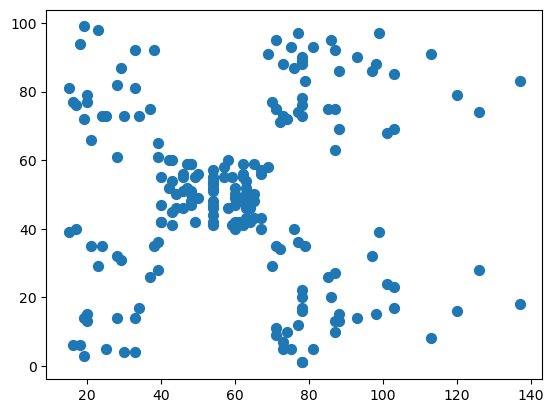

In [15]:
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], s = 50)

#### Implementasi Metode Elbow

C:\Users\WINDOWS 10\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WINDOWS 10\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WINDOWS 10\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WINDOWS 10\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a m

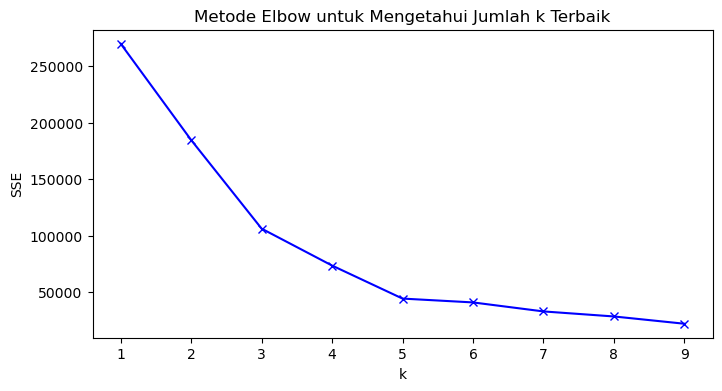

In [17]:
# List nilai SSE
sse = []
# Cari k terbaik dari 1-10
K = range(1,10)

for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    sse.append(kmeanModel.inertia_)

plt.figure(figsize=(8,4))
plt.plot(K, sse, "bx-")
plt.xlabel("k")
plt.ylabel("SSE")
plt.title("Metode Elbow untuk Mengetahui Jumlah k Terbaik")
plt.show()

In [18]:
# Cek nilai SSE setiap k
for idx, sse_val in enumerate(sse, start=1):
    print(f'k={idx}; SSE={sse_val}')

k=1; SSE=269981.28
k=2; SSE=184738.2194357367
k=3; SSE=106348.37306211119
k=4; SSE=73679.78903948834
k=5; SSE=44454.47647967974
k=6; SSE=41057.90230783709
k=7; SSE=33091.17539682539
k=8; SSE=28639.28446358519
k=9; SSE=22209.851608025543


Nilai k terbaik berada pada k=4

C:\Users\WINDOWS 10\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


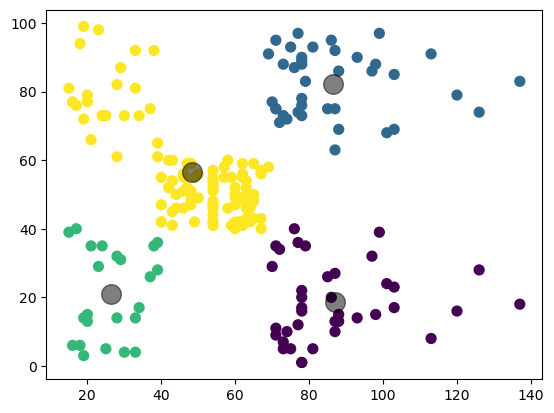

In [80]:
kmeans = KMeans(n_clusters=4)
y_kmeans = kmeans.fit_predict(X)

plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [82]:
# Cek Nilai SSE
print(f'Nilai SSE: {kmeans.inertia_}')

Nilai SSE: 73679.78903948834


### 4. Buatlah  implementasi model SOM untuk segmentasi citra lain

In [24]:
# Fungsi untuk menginisialisasi bobot SOM
def initialize_weights(input_shape, output_shape):
    return np.random.rand(output_shape[0], output_shape[1], input_shape[2])

In [25]:
# Fungsi untuk menghitung jarak antara vektor input dan bobot SOM
def calculate_distance(input_vector, weights):
    return np.linalg.norm(input_vector - weights, axis=2)

In [26]:
# Fungsi untuk menemukan indeks unit pemenang (unit dengan bobot terdekat)
def find_winner_unit_in_image(input_vector, weights):
    distances = calculate_distance(input_vector, weights)
    return np.unravel_index(np.argmin(distances), distances.shape)

In [27]:
# Fungsi untuk memperbarui bobot SOM
def update_weights(input_vector, weights, winner, learning_rate, neighborhood_radius):
    distances = np.linalg.norm(np.indices(weights.shape[:2]).T - np.array(winner).reshape(1, -1), axis=2)
    influence = np.exp(-distances / (2 * neighborhood_radius**2))
    weights += learning_rate * influence[:, :, np.newaxis] * (input_vector - weights)

In [28]:
# Fungsi untuk melatih SOM
def train_som(image, num_epochs, initial_learning_rate, initial_neighborhood_radius):
    input_shape = image.shape
    som_shape = (10, 10, input_shape[2])  # Ukuran SOM sesuai dengan jumlah saluran warna
    weights = initialize_weights(input_shape, som_shape)

    for epoch in range(num_epochs):
        # Update parameter pembelajaran dan radius tetangga
        learning_rate = initial_learning_rate * np.exp(-epoch / num_epochs)
        neighborhood_radius = initial_neighborhood_radius * np.exp(-epoch / num_epochs)
        # Pemrosesan SOM
        for i in range(input_shape[0]):
            for j in range(input_shape[1]):
                input_vector = image[i, j, :]
                winner = find_winner_unit_in_image(input_vector, weights)
                update_weights(input_vector, weights, winner, learning_rate, neighborhood_radius)

    return weights

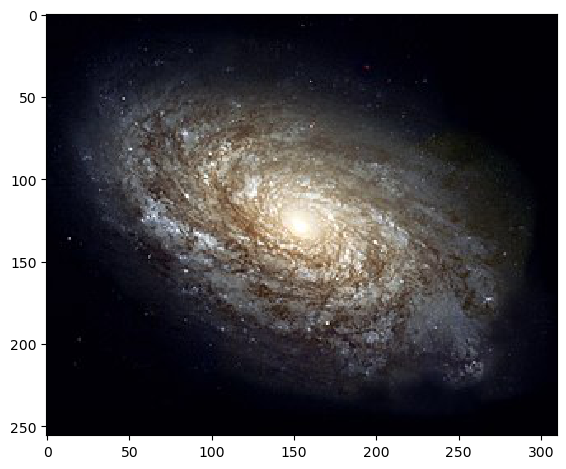

In [23]:
# Load citra
galaxy_path = "galaxy.jpg"
galaxy = io.imread(galaxy_path) / 255.0
io.imshow(galaxy)

In [29]:
# Latih SOM
num_epochs = 100
initial_learning_rate = 0.1
initial_neighborhood_radius = 5
trained_weights = train_som(galaxy, num_epochs, initial_learning_rate, initial_neighborhood_radius)

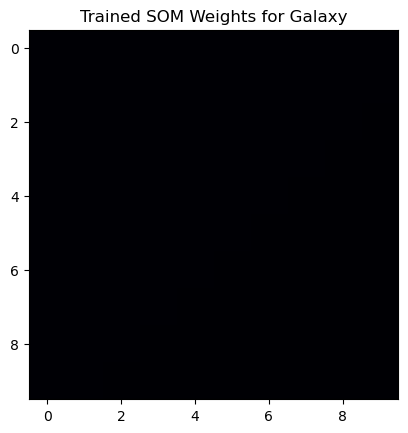

In [30]:
# Visualisasi bobot SOM
plt.imshow(trained_weights)
plt.title('Trained SOM Weights for Galaxy')
plt.show()

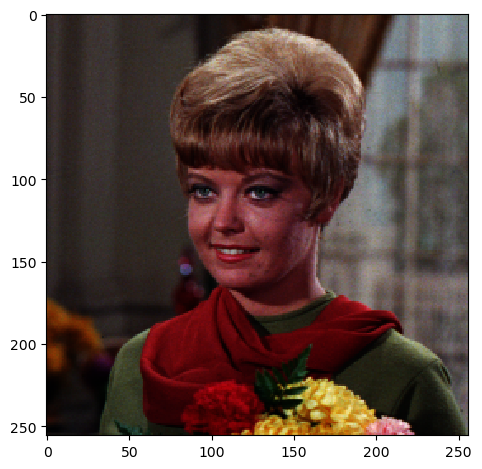

In [31]:
# Load citra
female_path = "female.tiff"
female = io.imread(female_path) / 255.0
io.imshow(female)

In [32]:
# Latih SOM
num_epochs = 100
initial_learning_rate = 0.1
initial_neighborhood_radius = 5
trained_weights = train_som(female, num_epochs, initial_learning_rate, initial_neighborhood_radius)

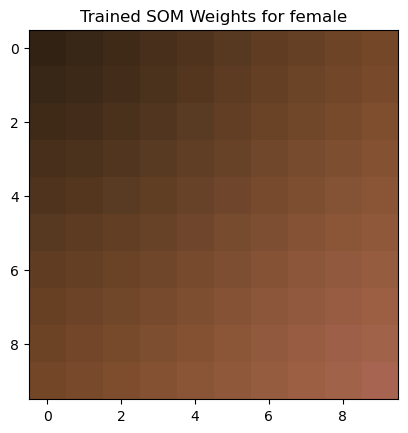

In [33]:
# Visualisasi bobot SOM
plt.imshow(trained_weights)
plt.title('Trained SOM Weights for female')
plt.show()